# **콜백을 적용한 CNN-MNIST와 과적합 대책 적용**

## **1. 라이브러리 불러오기**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

import time

In [2]:
(raw_train_x, raw_train_y), (raw_test_x, raw_test_y) = tf.keras.datasets.mnist.load_data()

train_x = raw_train_x/255
test_x = raw_test_x/255

# Conv2D는 width*height*channel을 입력으로 받음
train_x = train_x.reshape((60000, 28, 28, 1)) # ADDED
test_x = test_x.reshape((10000, 28, 28, 1)) # ADDED

train_y = raw_train_y
test_y = raw_test_y

11490434/11490434 [==============================] - 0s 0us/step


## **2. Callback 적용**
- Loss 그래프로 확인하기


In [3]:
# copy from https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

from IPython.display import clear_output

class PlotLosses(Callback):

  def on_train_begin(self, logs={}):

    self.i = 0
    self.x = []
    self.losses = []
    self.val_losses = []

    self.fig = plt.figure()

    self.logs = []


  def on_epoch_end(self, epoch, logs={}):

    self.logs.append(logs)
    self.x.append(self.i)
    self.losses.append(logs.get('loss'))
    self.val_losses.append(logs.get('val_loss'))
    self.i += 1

    clear_output(wait=True)
    plt.plot(self.x, self.losses, label="loss")
    plt.plot(self.x, self.val_losses, label="val_loss")
    plt.legend()
    plt.show();
    print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])



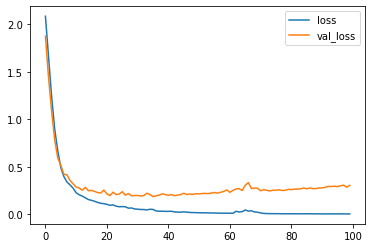

loss =  0.003448131959885359 , val_loss =  0.30418944358825684
313/313 [==============================] - 1s 3ms/step - loss: 0.2820 - accuracy: 0.9501
loss= 0.2820115089416504
acc= 0.9501000046730042
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [4]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=100, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


## **3. 과적합 대책**

### 3.1 Drop Out 적용

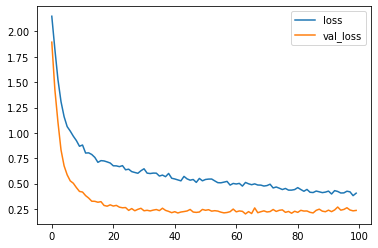

loss =  0.40523460507392883 , val_loss =  0.2351149469614029
313/313 [==============================] - 1s 3ms/step - loss: 0.2366 - accuracy: 0.9552
loss= 0.2366362065076828
acc= 0.9552000164985657
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [5]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) # ADDED
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) # ADDED
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2)) # ADDED
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2)) # ADDED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=100, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


### 3.2 배치 정규화 적용
- Batch Normalization

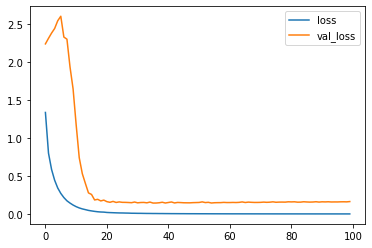

loss =  0.0005266155931167305 , val_loss =  0.16342748701572418
313/313 [==============================] - 1s 3ms/step - loss: 0.1534 - accuracy: 0.9593
loss= 0.15336690843105316
acc= 0.9592999815940857
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [6]:
from tensorflow.keras.layers import Dropout, BatchNormalization

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization()) # ADDED
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization()) # ADDED
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization()) # ADDED
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization()) # ADDED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=100, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)        

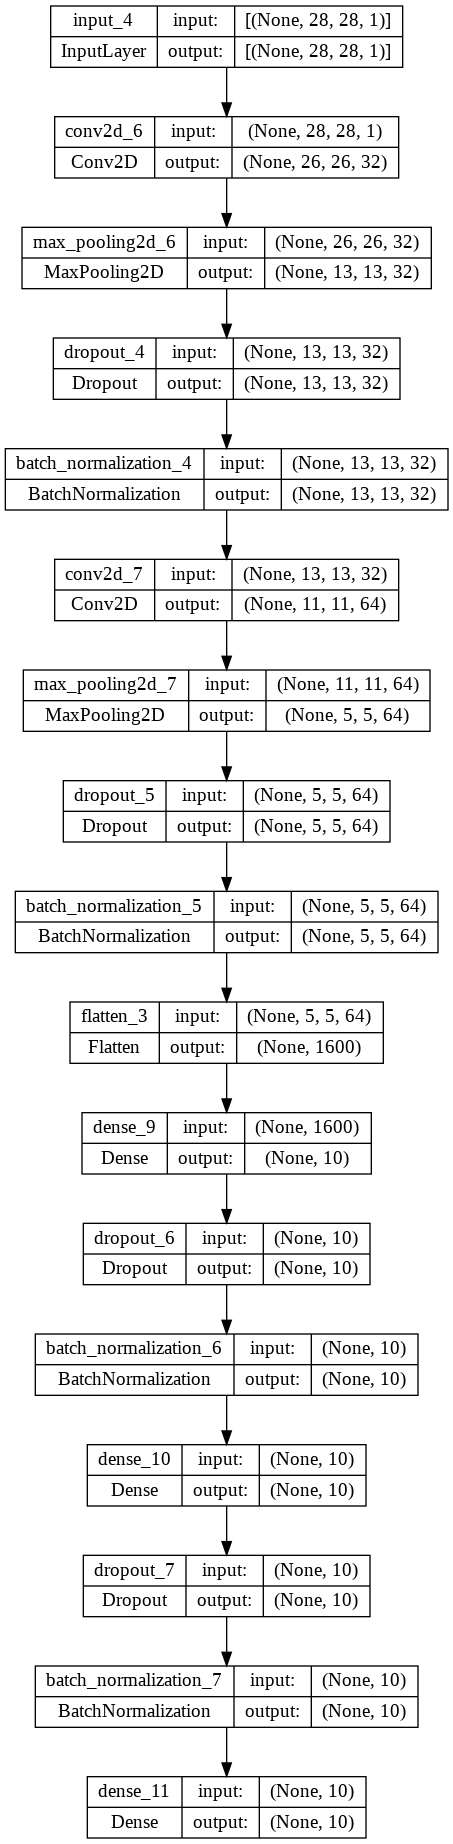

In [7]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) # ADDED
model.add(BatchNormalization()) # ADDED
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2)) # ADDED
model.add(BatchNormalization()) # ADDED
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2)) # ADDED
model.add(BatchNormalization()) # ADDED
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.2)) # ADDED
model.add(BatchNormalization()) # ADDED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

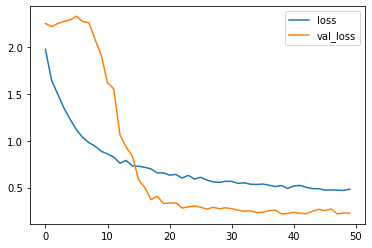

loss =  0.4831777811050415 , val_loss =  0.2250070720911026
313/313 [==============================] - 1s 3ms/step - loss: 0.2099 - accuracy: 0.9511
loss= 0.20994597673416138
acc= 0.9510999917984009
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [8]:
plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=50, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)


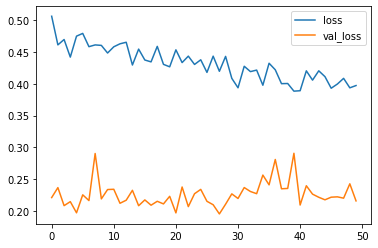

loss =  0.39731311798095703 , val_loss =  0.21550901234149933
313/313 [==============================] - 1s 3ms/step - loss: 0.1696 - accuracy: 0.9576
loss= 0.16961298882961273
acc= 0.9575999975204468


In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', # 모니터링 대상
                              factor=0.2,         # 줄이는 양
                              patience=50,         # 대상 기간동안 유지
                              min_learning_rate=0.00001)       # 최소 학습율


model.fit(train_x[:6000], train_y[:6000], epochs=50, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses, reduce_lr])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

### 3.3 DropOut, 배치 정규화 순서 바꾸기

- BatchNormalization, Dropout, Pooling 적용 순서
(출처: https://gaussian37.github.io/dl-concept-order_of_regularization_term/ )
  - 딥러닝 프레임워크를 이용하여 네트워크를 구성할 때 다양한 정규화 기법들을 사용함
  - 배치 정규화(batch normaliation), 드랍 아웃을 사용할 때, 어떤 순서로 사용하는 것이 좋은가? (출처 : stackoverflow)

- 주장 1
  - Convoluter Layer 또는 Fully Connected Layer 등의 layer 뒤에 적용되는 것이 맞다고 본다.
  - 그리고 ReLU와 같은 Activation function을 적용하기 전에 적용하는 것을 추천하고 있다.
  - 왜냐하면 배치 정규화의 목적이 네트워크 연산 결과가 원하는 방향의 분포대로 나오는 것이기 때문에 
  - 핵심 연산인 Convolution 연산 뒤에 바로 적용하여 정규화 하는 것이 핵심이다.
  - 즉, Activation function이 적용되어 분포가 달라지기 전에 적용하는 것이 올바른 방법이다.

- 주장 2
  - activation function을 적용한 뒤에 적용하는 것이 맞다고 본다.

- 주장 3
  - Convolution 연산과 함께 사용되는 pooling 연산은 정규화 기법 적용이 끝난 뒤에 적용하는 것을 추천한다.
  - 저자의 경험을 기반으로 하므로 정확하지 않을 수 있지만, dropout 이후에 적용하니 성능이 잘 나왔다.(물론 task마다 다르겠지만)

---

- 정리하면 Convolution - 배치 정규화 - Activation - Dropout - Pooling 순서로 네트워크를 구성하는 것이 좋음

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_8 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 5, 5, 64)        

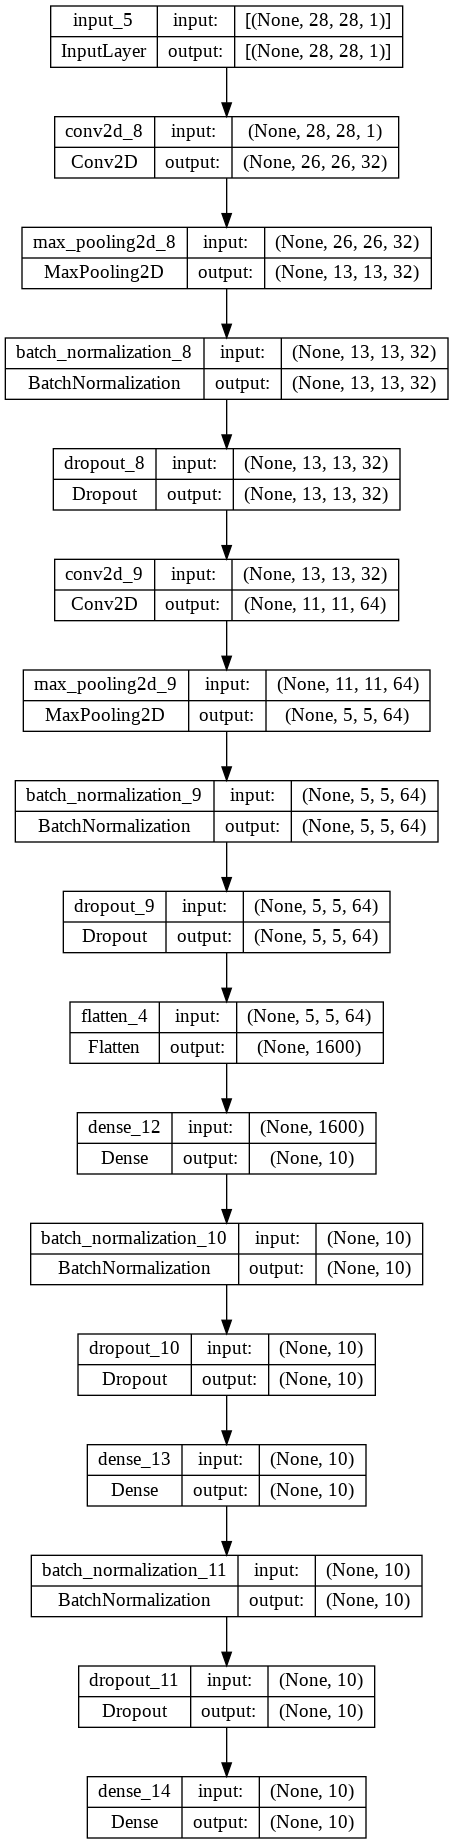

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))
model.add(Conv2D(32, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Conv2D(64, (3, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Dense(10, activation='relu'))
model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

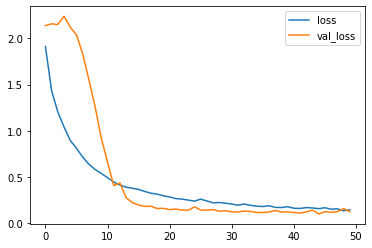

loss =  0.14615978300571442 , val_loss =  0.1263093501329422
313/313 [==============================] - 1s 3ms/step - loss: 0.0991 - accuracy: 0.9697
loss= 0.09912120550870895
acc= 0.9696999788284302
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [14]:
plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=50, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

In [15]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.0991 - accuracy: 0.9697
loss= 0.09912120550870895
acc= 0.9696999788284302


### 3.4 Conv 레이어들 추가

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 12, 12, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_12 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 10, 10, 64)       

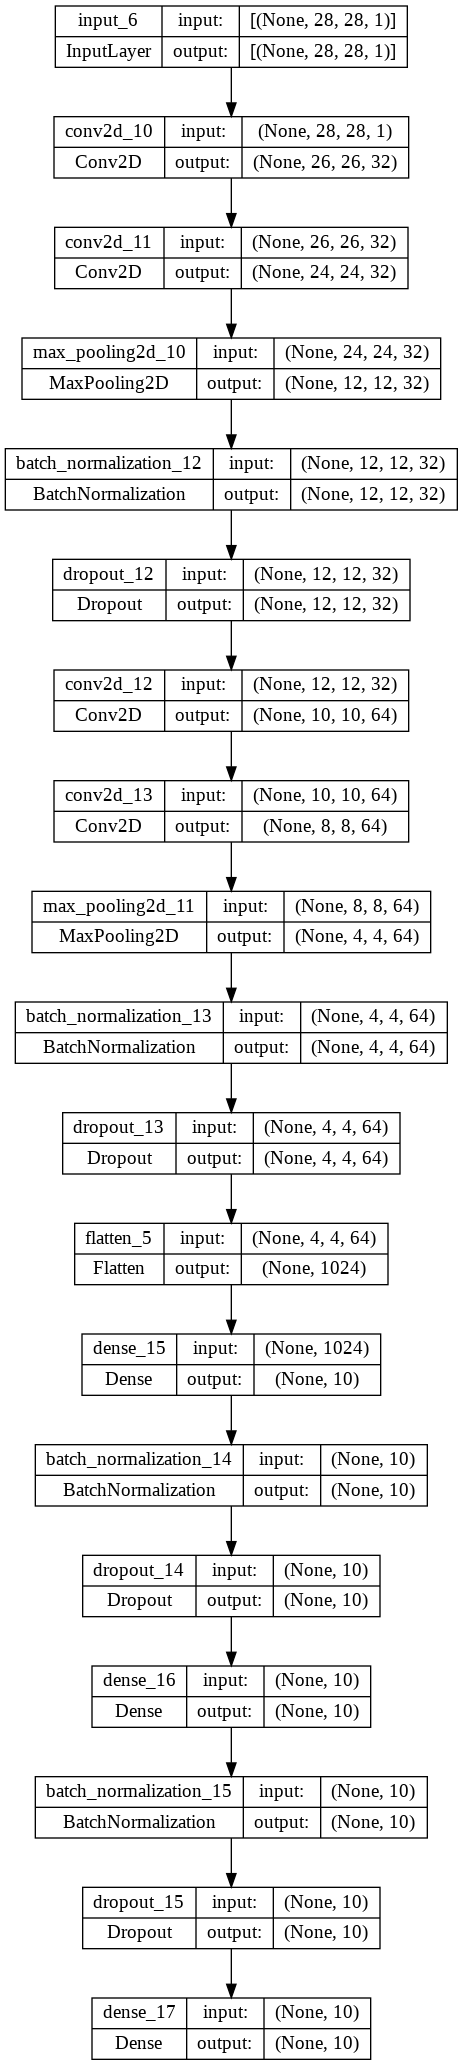

In [16]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))

model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3))) # ADDED
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3))) # ADDED
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Dense(10, activation='relu'))

model.add(BatchNormalization()) # MODIFIED
model.add(Dropout(0.2)) # MODIFIED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

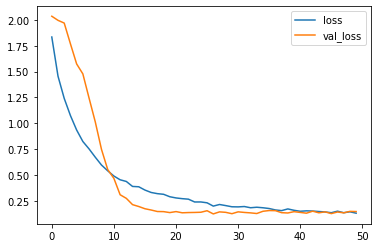

loss =  0.13129538297653198 , val_loss =  0.1470678597688675
313/313 [==============================] - 1s 3ms/step - loss: 0.1093 - accuracy: 0.9671
loss= 0.10929811745882034
acc= 0.9671000242233276
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [17]:
plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=10)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=50, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)

In [18]:
loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

313/313 [==============================] - 1s 3ms/step - loss: 0.1093 - accuracy: 0.9671
loss= 0.10929811745882034
acc= 0.9671000242233276


### 3.5 Dropout 확률 변경

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 12, 12, 32)       128       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 10, 10, 64)       

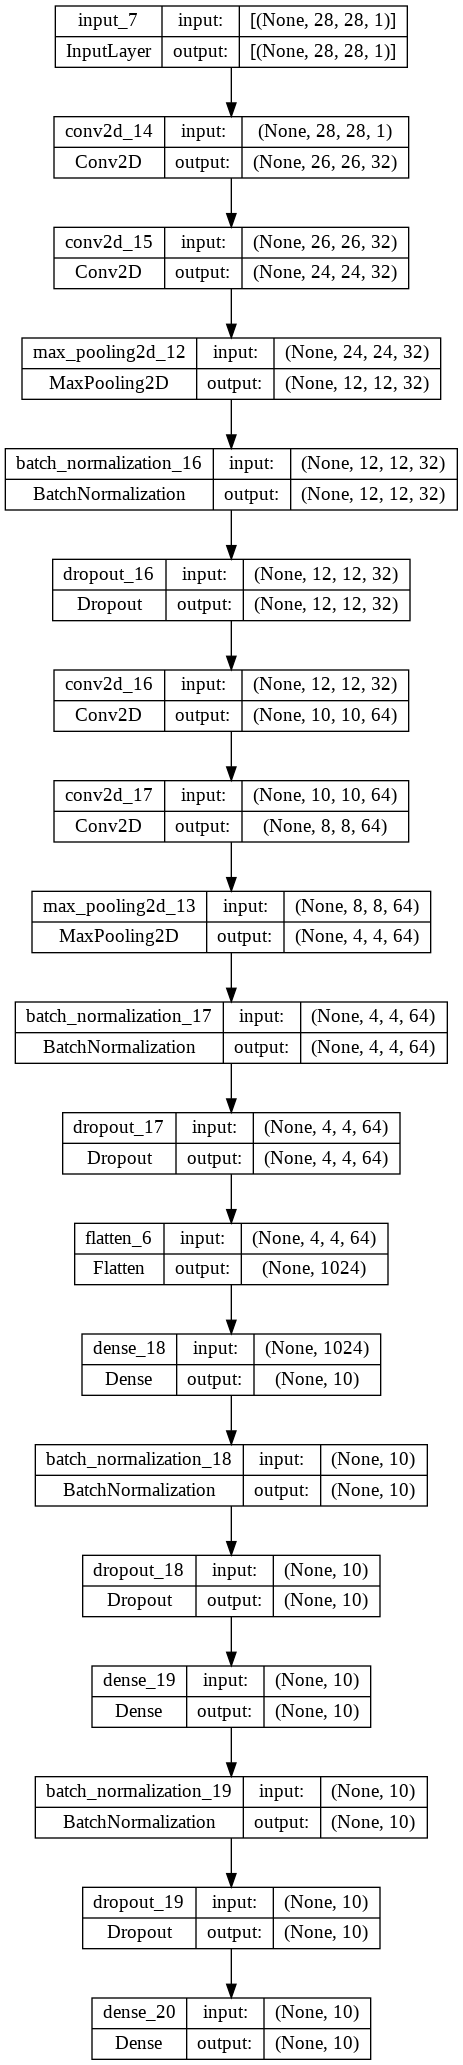

In [19]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential()
# model.add(Input((28,28)))
model.add(Input((28,28,1)))

model.add(Conv2D(32, (3, 3)))
model.add(Conv2D(32, (3, 3))) # ADDED
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3)))
model.add(Conv2D(64, (3, 3))) # ADDED
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5)) # MODIFIED
model.add(Dense(10, activation='relu'))

model.add(BatchNormalization())
model.add(Dropout(0.5)) # MODIFIED
model.add(Dense(10, activation='softmax'))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plot_model(model, to_file='model_shapes.png', show_shapes=True)

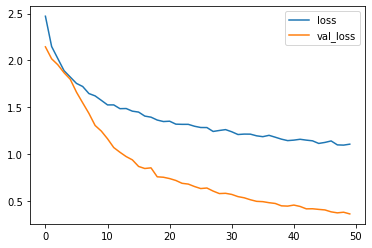

loss =  1.1064194440841675 , val_loss =  0.3625396192073822
313/313 [==============================] - 1s 3ms/step - loss: 0.3592 - accuracy: 0.9437
loss= 0.3592418432235718
acc= 0.9437000155448914
313/313 [==============================] - 1s 2ms/step
[7 2 1 ... 4 5 6]


In [20]:
plot_losses = PlotLosses()
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',  # 모니터링 대상
                               mode='auto',         # 학습 방향을 자동으로 탐지
                               patience=50)


# model.fit(train_x, train_y, epochs=5, verbose=1, batch_size=128)
model.fit(train_x[:6000], train_y[:6000], epochs=50, verbose=1, batch_size=128, validation_split=0.2, 
          callbacks=[plot_losses, early_stopping])


loss, acc = model.evaluate(test_x, test_y)
print("loss=",loss)
print("acc=",acc)

y_ = model.predict(test_x)
predicted = np.argmax(y_, axis=1)

print(predicted)